In [ ]:
import os
import kagglehub
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import discriminant_analysis as lda
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from collections import Counter
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from collections import Counter

# **Download Kaggle:**
https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

In [ ]:
# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:07<00:00, 113MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


# Classificação das imagens  (COVID, Lung Opacity, Normal, Viral Pneumonia):

In [ ]:
def load_dataset(dataset_path):
    images = []
    labels = []
    class_map = {}

    base_path = os.path.join(dataset_path, 'COVID-19_Radiography_Dataset')
    class_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(base_path, class_folder)
        images_path = os.path.join(class_path, 'images')

        if os.path.exists(images_path):
            class_map[idx] = class_folder  # Garante que o mapeamento de classes seja preenchido
            for image_filename in os.listdir(images_path):
                image_path = os.path.join(images_path, image_filename)
                images.append(image_path)
                labels.append(idx)

    return images, labels, class_map


In [ ]:
class XRayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Definição de transformações para EfficientNet-B0
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
images, labels, class_map = load_dataset(path)
dataset = XRayDataset(images, labels, transform=transform)

In [ ]:


# Separar dataset em treino e validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Contagem de imagens por classe no conjunto de treino e validação
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print("Quantidade de imagens por classe no conjunto de TREINO:")
for idx, count in train_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

print("\nQuantidade de imagens por classe no conjunto de VALIDAÇÃO:")
for idx, count in val_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

Quantidade de imagens por classe no conjunto de TREINO:
Normal: 8167 imagens
Viral Pneumonia: 1081 imagens
Lung_Opacity: 4774 imagens
COVID: 2910 imagens

Quantidade de imagens por classe no conjunto de VALIDAÇÃO:
Lung_Opacity: 1238 imagens
Normal: 2025 imagens
Viral Pneumonia: 264 imagens
COVID: 706 imagens


In [ ]:
# Carregar modelo EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_map))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.3MB/s]


In [ ]:
# Definir loss e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Mover modelo para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:


# Listas para armazenar os valores de Loss e Acurácia
epochs_list = []
loss_list = []
accuracy_list = []

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epochs_list.append(epoch + 1)
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Treinamento concluído!")

Epoch 1/3, Loss: 0.2508, Accuracy: 91.06%
Epoch 2/3, Loss: 0.1383, Accuracy: 95.30%
Epoch 3/3, Loss: 0.1004, Accuracy: 96.46%
Treinamento concluído!


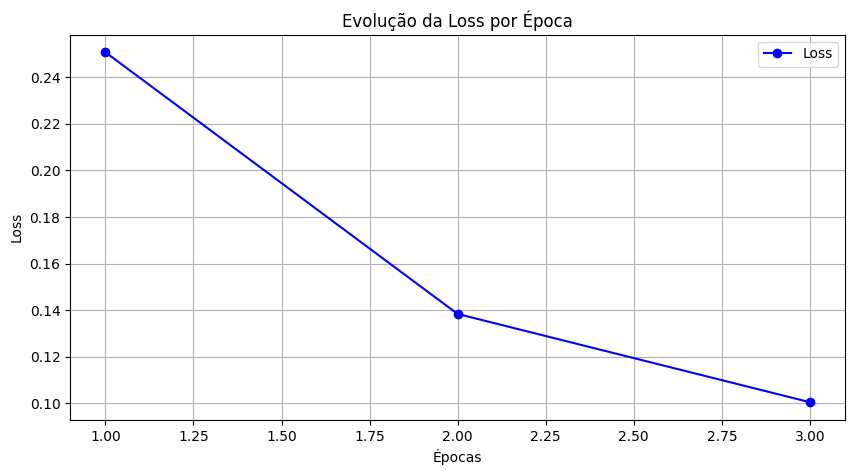

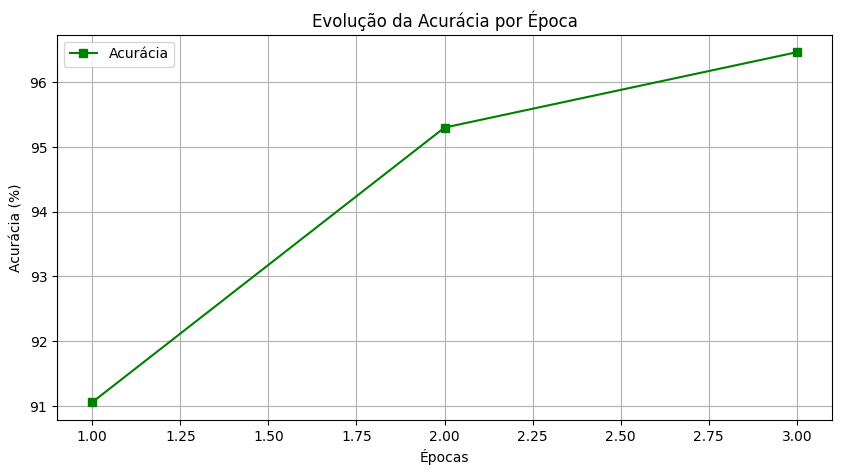

In [ ]:
# Gráfico da Loss por época
plt.figure(figsize=(10,5))
plt.plot(epochs_list, loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss por Época')
plt.legend()
plt.grid()
plt.show()

# Gráfico da Acurácia por época
plt.figure(figsize=(10,5))
plt.plot(epochs_list, accuracy_list, marker='s', linestyle='-', color='g', label='Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (%)')
plt.title('Evolução da Acurácia por Época')
plt.legend()
plt.grid()
plt.show()


In [ ]:


# Validação do modelo
model.eval()
val_loss = 0.0
correct = 0
total = 0
val_losses = []
val_accuracies = []
class_correct = Counter()
class_total = Counter()
class_losses = Counter()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Contabilizando acertos e erros por classe
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels[i]:
                class_correct[label] += 1

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.1604, Accuracy: 94.59%

Acurácia por classe:
Classe Viral Pneumonia: Acurácia: 98.89%, Loss: 0.1457
Classe Lung_Opacity: Acurácia: 94.85%, Loss: 0.1612
Classe Normal: Acurácia: 95.21%, Loss: 0.1639
Classe COVID: Acurácia: 90.77%, Loss: 0.1580


# **Primeira validação sem utilizar predição**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

# Validação do modelo
model.eval()
val_loss = 0.0
correct = 0
total = 0
val_losses = []
val_accuracies = []
class_correct = Counter()
class_total = Counter()
class_losses = Counter()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Armazena previsões e rótulos reais para métricas
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Contabilizando acertos e erros por classe
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels[i]:
                class_correct[label] += 1

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.1861, Accuracy: 94.61%


In [ ]:
print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Exibir acurácia por classe
class_names = [class_map[idx] for idx in class_total.keys()]
class_accuracies = [100 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0 for idx in class_total.keys()]
class_losses_avg = [class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0 for idx in class_total.keys()]

print("\nAcurácia por classe:")
for name, acc, loss in zip(class_names, class_accuracies, class_losses_avg):
    print(f"Classe {name}: Acurácia: {acc:.2f}%, Loss: {loss:.4f}")

Validation Loss: 0.1861, Accuracy: 94.61%

Acurácia por classe:
Classe Normal: Acurácia: 98.58%, Loss: 0.1778
Classe Viral Pneumonia: Acurácia: 96.99%, Loss: 0.1972
Classe Lung_Opacity: Acurácia: 85.23%, Loss: 0.1986
Classe COVID: Acurácia: 98.46%, Loss: 0.1815


In [ ]:
# Armazenar métricas sem exibir os gráficos
cm = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_map.values(), output_dict=True)

# Exibir as métricas de forma estruturada
confusion_matrix_data = {
    "Matriz de Confusão": cm.tolist(),
    "Relatório de Classificação": classification_rep
}

print("\nMatriz de Confusão:")
print(cm)
print("\nRelatório de Classificação:")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}, Support: {metrics['support']}")



Matriz de Confusão:
[[ 258    1    7    0]
 [   1  701   10    0]
 [   3    3 2007   23]
 [   0    6  174 1039]]

Relatório de Classificação:
Viral Pneumonia: Precision: 0.98, Recall: 0.97, F1-score: 0.98, Support: 266.0
COVID: Precision: 0.99, Recall: 0.98, F1-score: 0.99, Support: 712.0
Normal: Precision: 0.91, Recall: 0.99, F1-score: 0.95, Support: 2036.0
Lung_Opacity: Precision: 0.98, Recall: 0.85, F1-score: 0.91, Support: 1219.0
macro avg: Precision: 0.97, Recall: 0.95, F1-score: 0.96, Support: 4233.0
weighted avg: Precision: 0.95, Recall: 0.95, F1-score: 0.95, Support: 4233.0


In [ ]:

# Exibir acurácia por classe
class_names = [class_map[idx] for idx in class_total.keys()]
class_accuracies = [100 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0 for idx in class_total.keys()]
class_losses_avg = [class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0 for idx in class_total.keys()]

print("\nAcurácia por classe:")
for name, acc, loss in zip(class_names, class_accuracies, class_losses_avg):
    print(f"Classe {name}: Acurácia: {acc:.2f}%, Loss: {loss:.4f}")



Acurácia por classe:
Classe Normal: Acurácia: 98.58%, Loss: 0.1778
Classe Viral Pneumonia: Acurácia: 96.99%, Loss: 0.1972
Classe Lung_Opacity: Acurácia: 85.23%, Loss: 0.1986
Classe COVID: Acurácia: 98.46%, Loss: 0.1815


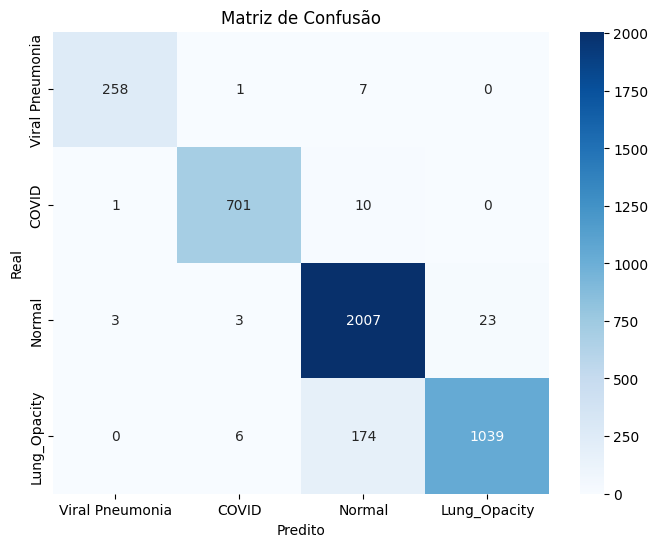

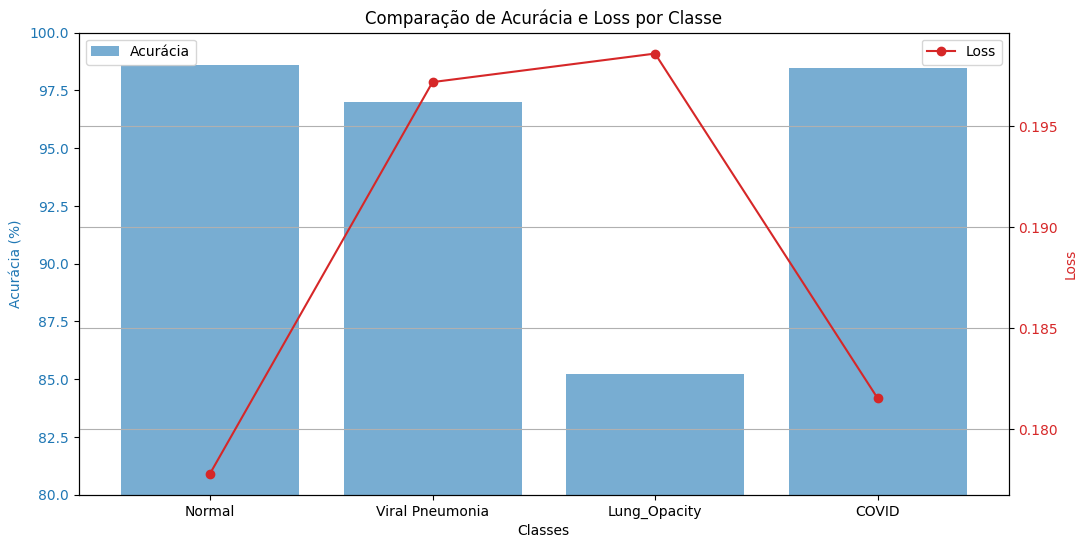

In [ ]:
# Gráficos da Matriz de Confusão e Relatório de Classificação
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_map.values(), yticklabels=class_map.values())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Gráfico comparando classes - Acurácia e Loss
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acurácia (%)', color='tab:blue')
ax1.bar(class_names, class_accuracies, color='tab:blue', alpha=0.6, label='Acurácia')
ax1.set_ylim(80, 100)  # Ajustando os limites do eixo Y para destacar as diferenças
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Comparação de Acurácia e Loss por Classe')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
# Gráfico comparando classes - Acurácia e Loss
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acurácia (%)', color='tab:blue')
ax1.bar(class_names, class_accuracies, color='tab:blue', alpha=0.6, label='Acurácia')
ax1.set_ylim(80, 100)  # Ajustando os limites do eixo Y para destacar as diferenças
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.set_ylim(0.14, 0.17)  # Ajustando os limites do eixo Y para destacar as diferenças
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Comparação de Acurácia e Loss por Classe')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Gráfico da Loss e Acurácia na validação
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Validação')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(val_losses, marker='o', linestyle='-', color='r', label='Loss de Validação')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Acurácia (%)', color='tab:blue')
ax2.plot(val_accuracies, marker='s', linestyle='-', color='b', label='Acurácia de Validação')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Evolução da Validação: Loss e Acurácia')
plt.grid()
plt.show()


NameError: name 'plt' is not defined

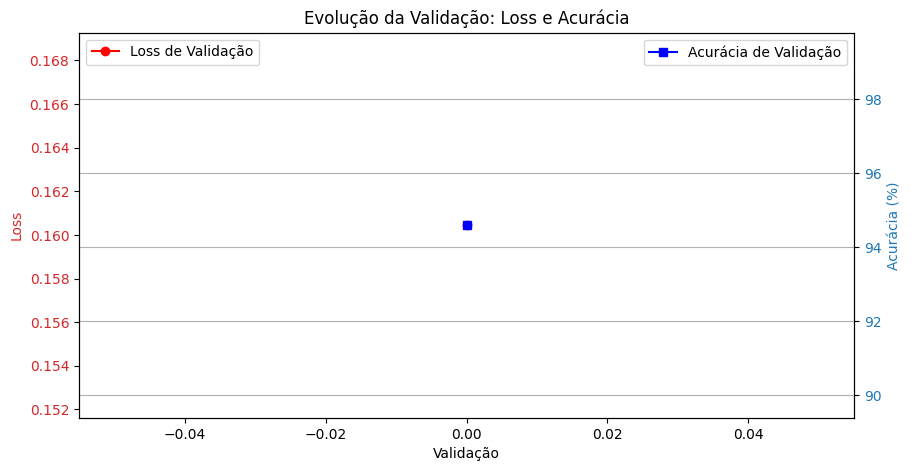

In [ ]:
# Gráfico da Loss e Acurácia na validação
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Validação')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(val_losses, marker='o', linestyle='-', color='r', label='Loss de Validação')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Acurácia (%)', color='tab:blue')
ax2.plot(val_accuracies, marker='s', linestyle='-', color='b', label='Acurácia de Validação')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Evolução da Validação: Loss e Acurácia')
plt.grid()
plt.show()

Validação utilizando Predição


In [ ]:
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from sklearn.model_selection import train_test_split

# Validação do modelo
model.eval()
val_loss = 0.0
correct = 0
total = 0
val_losses = []
val_accuracies = []
class_correct = Counter()
class_total = Counter()
class_losses = Counter()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Armazena previsões e probabilidades
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        # Contabilizando acertos e erros por classe
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels[i]:
                class_correct[label] += 1

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.1376, Accuracy: 95.39%


In [ ]:
# Armazenar métricas sem exibir os gráficos
cm = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_map.values(), output_dict=True)

# Exibir as métricas de forma estruturada
confusion_matrix_data = {
    "Matriz de Confusão": cm.tolist(),
    "Relatório de Classificação": classification_rep
}

print("\nMatriz de Confusão:")
print(cm)
print("\nRelatório de Classificação:")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}, Support: {metrics['support']}")




Matriz de Confusão:
[[1113    0    5  120]
 [   0  244    1   19]
 [   4    1  697    4]
 [  34    1    6 1984]]

Relatório de Classificação:
Lung_Opacity: Precision: 0.97, Recall: 0.90, F1-score: 0.93, Support: 1238.0
Viral Pneumonia: Precision: 0.99, Recall: 0.92, F1-score: 0.96, Support: 264.0
COVID: Precision: 0.98, Recall: 0.99, F1-score: 0.99, Support: 706.0
Normal: Precision: 0.93, Recall: 0.98, F1-score: 0.96, Support: 2025.0
macro avg: Precision: 0.97, Recall: 0.95, F1-score: 0.96, Support: 4233.0
weighted avg: Precision: 0.95, Recall: 0.95, F1-score: 0.95, Support: 4233.0


In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# Separar 20% dos dados de validação como calibração
probs_np = np.array(all_probs)
labels_np = np.array(all_labels)

X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(probs_np, labels_np, test_size=0.2, random_state=42)

# Passo 1: calcular não conformidade do conjunto de calibração
nonconformity_scores = []
for i in range(len(X_calib)):
    prob = X_calib[i]
    true_label = y_calib[i]
    score = 1.0 - prob[true_label]
    nonconformity_scores.append(score)

nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores_sorted = np.sort(nonconformity_scores)

# Passo 2: definir nível de confiança
alpha = 0.05
q_hat = np.quantile(nonconformity_scores_sorted, 1 - alpha)

# Passo 3: gerar conjuntos preditos para os dados restantes
prediction_sets = []
correct_in_set = 0

for i in range(len(X_val_conf)):
    prob = X_val_conf[i]
    pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]
    prediction_sets.append(pred_set)

    if y_val_conf[i] in pred_set:
        correct_in_set += 1

# Passo 4: métricas
coverage = correct_in_set / len(X_val_conf)
avg_set_size = np.mean([len(p) for p in prediction_sets])

print(f"\n✅ Conformal Prediction Manual:")
print(f"Cobertura (acerto): {coverage:.2f}")
print(f"Tamanho médio do conjunto predito: {avg_set_size:.2f}")


✅ Conformal Prediction Manual:
Cobertura (acerto): 0.94
Tamanho médio do conjunto predito: 0.98


In [ ]:
def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]
        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

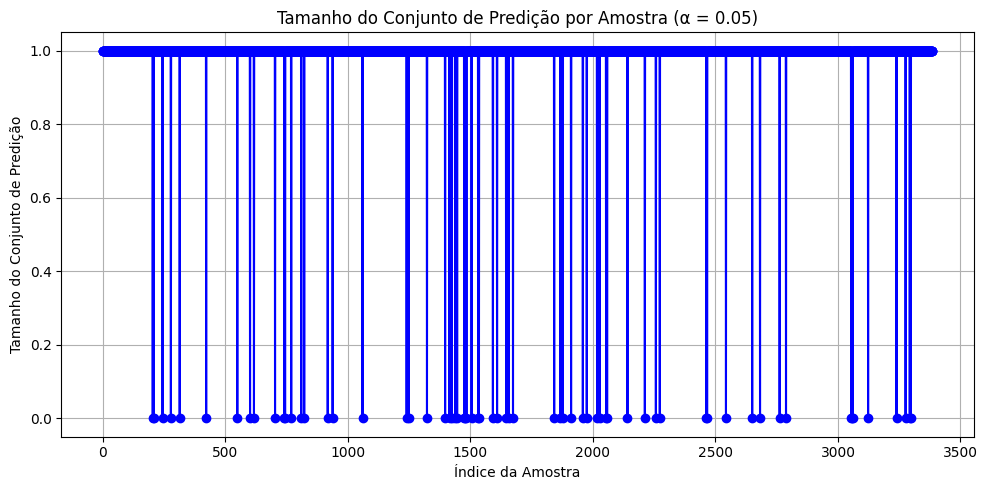

In [ ]:
# Gerar gráfico 1: tamanho do conjunto de predição por amostra
alpha_fixed = 0.05
_, _, nonconformity_scores = X_val_conf, y_val_conf, [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

sets, _, _ = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_fixed)
set_sizes = [len(s) for s in sets]

plt.figure(figsize=(10, 5))
plt.plot(range(len(set_sizes)), set_sizes, marker='o', linestyle='-', color='blue')
plt.xlabel("Índice da Amostra")
plt.ylabel("Tamanho do Conjunto de Predição")
plt.title(f"Tamanho do Conjunto de Predição por Amostra (α = {alpha_fixed})")
plt.grid(True)
plt.tight_layout()
plt.show()



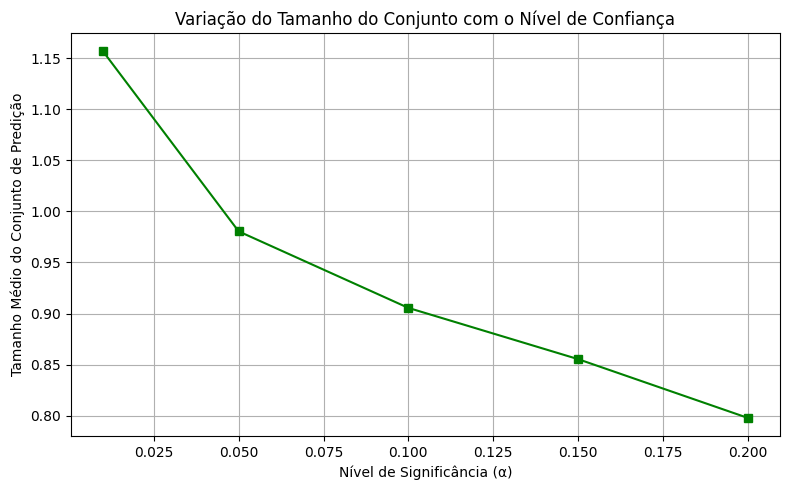

In [ ]:
# Gerar gráfico 2: variação do tamanho médio do conjunto com diferentes alphas
alphas = [0.01, 0.05, 0.10, 0.15, 0.20]
avg_sizes = []

for a in alphas:
    _, _, avg = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, a)
    avg_sizes.append(avg)

plt.figure(figsize=(8, 5))
plt.plot(alphas, avg_sizes, marker='s', linestyle='-', color='green')
plt.xlabel("Nível de Significância (α)")
plt.ylabel("Tamanho Médio do Conjunto de Predição")
plt.title("Variação do Tamanho do Conjunto com o Nível de Confiança")
plt.grid(True)
plt.tight_layout()
plt.show()


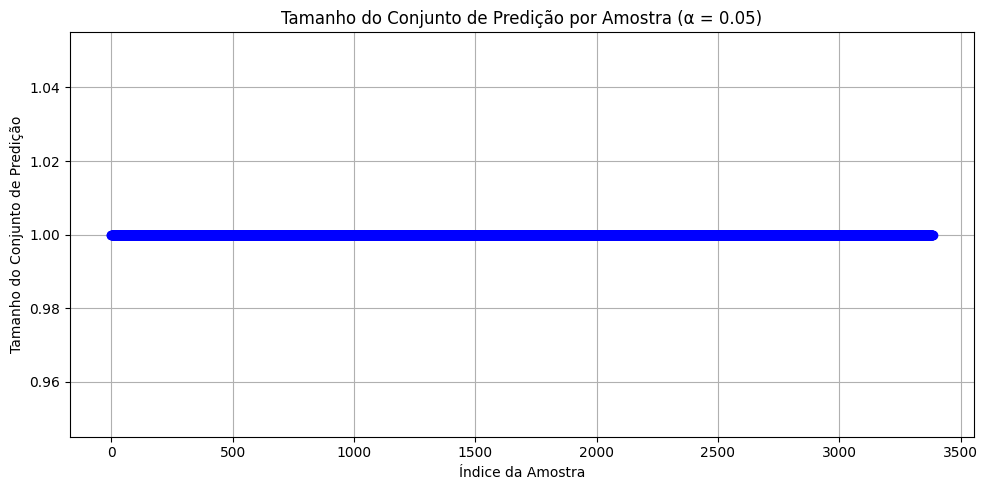


📋 Tabela: Frequência dos Tamanhos de Conjunto de Predição (Gráfico 1)
 Tamanho do Conjunto  Quantidade de Amostras
                   1                    3386


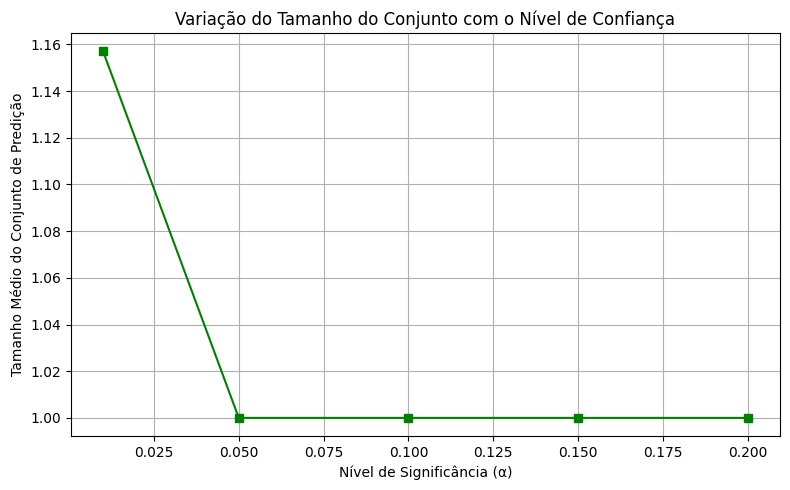


📋 Tabela: Tamanho Médio do Conjunto por Nível de Confiança (Gráfico 2)
 Alpha (nível de significância)  Tamanho Médio do Conjunto
                           0.01                   1.157118
                           0.05                   1.000000
                           0.10                   1.000000
                           0.15                   1.000000
                           0.20                   1.000000


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Supondo que all_probs e all_labels já tenham sido definidos durante a validação
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    np.array(all_probs), np.array(all_labels), test_size=0.2, random_state=42
)

# Função para gerar conjuntos de predição

def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]

        # Correção: se conjunto estiver vazio, incluir a classe de maior probabilidade
        if len(pred_set) == 0:
            pred_set = [int(np.argmax(prob))]

        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

# Etapa 1: calcular não conformidade para calibração
nonconformity_scores = [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

# Gráfico 1: tamanho do conjunto de predição por amostra
alpha_fixed = 0.05
sets, _, _ = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_fixed)
set_sizes = [len(s) for s in sets]

plt.figure(figsize=(10, 5))
plt.plot(range(len(set_sizes)), set_sizes, marker='o', linestyle='-', color='blue')
plt.xlabel("Índice da Amostra")
plt.ylabel("Tamanho do Conjunto de Predição")
plt.title(f"Tamanho do Conjunto de Predição por Amostra (α = {alpha_fixed})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabela 1: Frequência de tamanhos
unique_sizes, counts = np.unique(set_sizes, return_counts=True)
df_tamanho_conjunto = pd.DataFrame({
    "Tamanho do Conjunto": unique_sizes,
    "Quantidade de Amostras": counts
})
print("\n📋 Tabela: Frequência dos Tamanhos de Conjunto de Predição (Gráfico 1)")
print(df_tamanho_conjunto.to_string(index=False))

# Gráfico 2: variação do tamanho médio do conjunto com diferentes alphas
alphas = [0.01, 0.05, 0.10, 0.15, 0.20]
avg_sizes = []

for a in alphas:
    _, _, avg = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, a)
    avg_sizes.append(avg)

plt.figure(figsize=(8, 5))
plt.plot(alphas, avg_sizes, marker='s', linestyle='-', color='green')
plt.xlabel("Nível de Significância (α)")
plt.ylabel("Tamanho Médio do Conjunto de Predição")
plt.title("Variação do Tamanho do Conjunto com o Nível de Confiança")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabela 2: Alpha vs Tamanho Médio
df_variacao_alpha = pd.DataFrame({
    "Alpha (nível de significância)": alphas,
    "Tamanho Médio do Conjunto": avg_sizes
})
print("\n📋 Tabela: Tamanho Médio do Conjunto por Nível de Confiança (Gráfico 2)")
print(df_variacao_alpha.to_string(index=False))

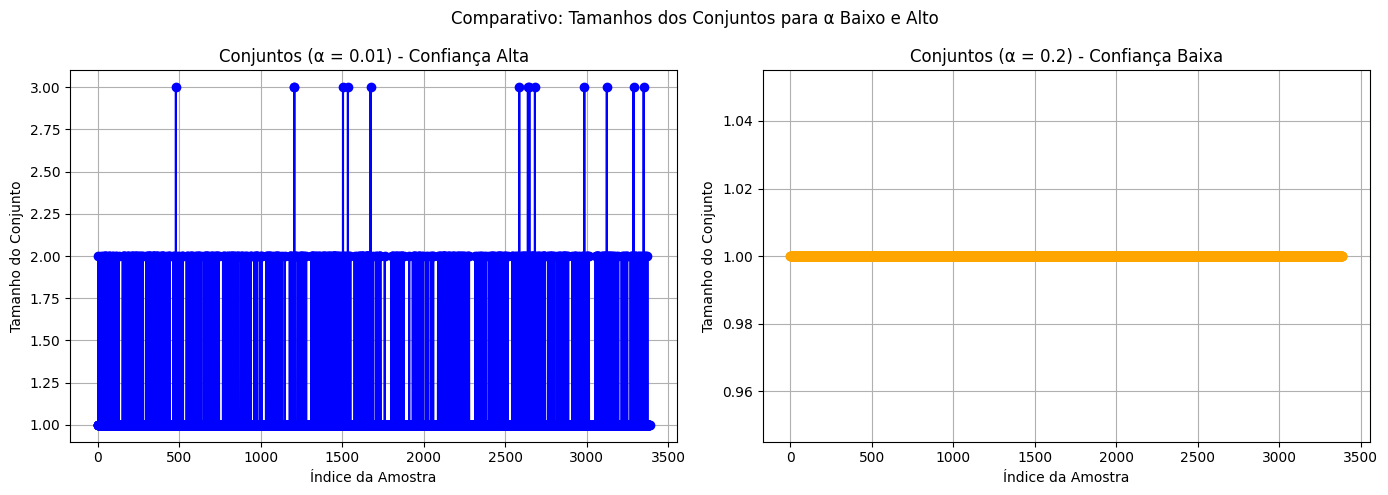


📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)
 Tamanho do Conjunto (α = 0.01)  Quantidade
                              1        2868
                              2         504
                              3          14

📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)
 Tamanho do Conjunto (α = 0.20)  Quantidade
                              1        3386


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Supondo que all_probs e all_labels já tenham sido definidos durante a validação
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    np.array(all_probs), np.array(all_labels), test_size=0.2, random_state=42
)

# Função para gerar conjuntos de predição

def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]

        # Correção: se conjunto estiver vazio, incluir a classe de maior probabilidade
        if len(pred_set) == 0:
            pred_set = [int(np.argmax(prob))]

        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

# Etapa 1: calcular não conformidade para calibração
nonconformity_scores = [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

# Testar alpha menos permissivo (maior confiança)
alpha_low = 0.01
sets_low, cov_low, avg_low = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_low)
set_sizes_low = [len(s) for s in sets_low]

# Testar alpha mais permissivo (menor confiança)
alpha_high = 0.20
sets_high, cov_high, avg_high = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_high)
set_sizes_high = [len(s) for s in sets_high]

# Gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(range(len(set_sizes_low)), set_sizes_low, marker='o', linestyle='-', color='blue')
axs[0].set_title(f"Conjuntos (α = {alpha_low}) - Confiança Alta")
axs[0].set_xlabel("Índice da Amostra")
axs[0].set_ylabel("Tamanho do Conjunto")
axs[0].grid(True)

axs[1].plot(range(len(set_sizes_high)), set_sizes_high, marker='o', linestyle='-', color='orange')
axs[1].set_title(f"Conjuntos (α = {alpha_high}) - Confiança Baixa")
axs[1].set_xlabel("Índice da Amostra")
axs[1].set_ylabel("Tamanho do Conjunto")
axs[1].grid(True)

plt.suptitle("Comparativo: Tamanhos dos Conjuntos para α Baixo e Alto")
plt.tight_layout()
plt.show()

# Tabelas comparativas
unique_low, count_low = np.unique(set_sizes_low, return_counts=True)
df_low = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.01)": unique_low,
    "Quantidade": count_low
})

unique_high, count_high = np.unique(set_sizes_high, return_counts=True)
df_high = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.20)": unique_high,
    "Quantidade": count_high
})

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)")
print(df_low.to_string(index=False))

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)")
print(df_high.to_string(index=False))
